In [79]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from get_json_data import load_data
from model import DeepModel
import pandas as pd
import numpy as np
import math

In [80]:
print('Loading training data')
data_name = "movie_score_train.json"
x, y = load_data(data_name)

Loading training data


In [81]:
print(x[0])
print(y[0])

[  7  20   0  25  60  11  37  55  99 175 178 185 168  99 183 171 168 176
 168  11  38  99   0  19  55   3  27  60  12  23  40  11  39  43  99   9
  23  43  11  36  47   0  28  99  11  25  60   9  19   0  39  11  24   9
  23  99   2  19  11  27   2  37  43  99   3  19  47  15  27  55  18  19
  43  99  15  39   9  37  99  12  19  60   6  25  43   3  37  47  11  37
  47  99   7  27   6  25  99  16  27  16  27  11  38  99  18  30   9  19
  60  11  24  99  12  23  61  11  37  43   3  37  58  18  19  43  99  11
  20  12  19  43  18  19  43  99  17  31  12  23  60  99  12  39   0  37
  55   3  27  99  11  39  61  11  37  47   9  32   0  19  99  11  23  57
   3  19  99   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
9


In [82]:
print(set(y))
y = to_categorical(y)
print(y[0])

{0, 3, 4, 5, 6, 7, 8, 9}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [83]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [84]:
sequence_length = 200 #x.shape[1] 
character_size = 251 # 251
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

In [85]:
epochs = 3
batch_size = 30
MODEL_WEIGHTS_FILE = 'recipe_weights.h5'

In [86]:
# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=character_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=10, activation='softmax')(dropout)

Creating Model...


In [87]:
# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

callbacks = [learning_rate_reduction,
             EarlyStopping('val_loss', patience=2),
             ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')]

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=(X_test, y_test))  # starts training

Traning Model...
Train on 1960 samples, validate on 490 samples
Epoch 1/3
1960/1960 [==============================] - 69s 35ms/step - loss: 0.1811 - acc: 0.9365 - val_loss: 0.1097 - val_acc: 0.9704

Epoch 00001: val_acc improved from -inf to 0.97041, saving model to recipe_weights.h5
Epoch 2/3
1960/1960 [==============================] - 66s 34ms/step - loss: 0.1099 - acc: 0.9695 - val_loss: 0.1022 - val_acc: 0.9714

Epoch 00002: val_acc improved from 0.97041 to 0.97143, saving model to recipe_weights.h5
Epoch 3/3
1960/1960 [==============================] - 61s 31ms/step - loss: 0.1050 - acc: 0.9695 - val_loss: 0.1001 - val_acc: 0.9714

Epoch 00003: val_acc did not improve


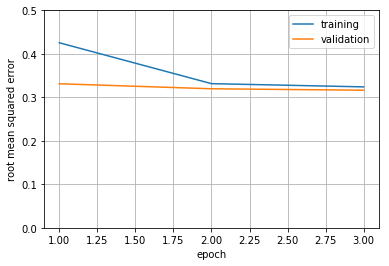

In [88]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.loc[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,0.5]);

In [89]:
print('Loading test data')
test_name = "movie_score_test.json"
x, y = load_data(test_name)

Loading test data


In [90]:
print(x[0])
print(y[0])

[14 30  0 27 99  6 25 60 12 19 40 99 12 23 60  6 19 47 99  0 19 55  3 27
 60 12 23 40 11 39  3 19 99 18 19 60  9 19 60 99  2 20 99  0 35 58  0 19
 11 24 43 99  2 27  5 20 58  9 27  5 39  0 19 99 99 99 99  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
9


In [96]:
pred = model.predict(x).argmax(axis=1)

In [97]:
import sklearn
acc = sklearn.metrics.accuracy_score(y, pred)
acc

0.98